In [39]:
#Imports
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor, Compose, Normalize, Resize, RandomCrop, RandomHorizontalFlip
from tqdm import tqdm
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
import torch.nn as nn
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR  # or ReduceLROnPlateau

In [2]:
#Set Random Seed
np.random.seed(0)
torch.manual_seed(0)

In [33]:
def patchify(images, n_patches):
    n, c, h, w = images.shape
    assert h == w, "Patchify method is implemented for square images only"
    patch_size = h // n_patches
    patches = torch.zeros(n, n_patches**2, c * patch_size * patch_size)

    for idx, image in enumerate(images):
        for i in range(n_patches):
            for j in range(n_patches):
                patch = image[
                    :,
                    i * patch_size : (i + 1) * patch_size,
                    j * patch_size : (j + 1) * patch_size,
                ]
                patches[idx, i * n_patches + j] = patch.flatten()
    return patches

def get_positional_embeddings(sequence_length, d):
    result = torch.zeros(sequence_length, d)
    for i in range(sequence_length):
        for j in range(0, d, 2):
            result[i][j] = np.sin(i / (10000 ** (j / d)))
            if j + 1 < d:
                result[i][j + 1] = np.cos(i / (10000 ** (j / d)))
    return result

class MyMSA(nn.Module):
    def __init__(self, d, n_heads=1):
        super(MyMSA, self).__init__()
        assert d % n_heads == 0, "Embedding dim must be divisible by number of heads"
        self.d_head = d // n_heads
        self.n_heads = n_heads

        self.qkv = nn.Linear(d, 3 * d)
        self.out_proj = nn.Linear(d, d)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        B, N, D = x.shape
        qkv = self.qkv(x)  # [B, N, 3*D]
        qkv = qkv.view(B, N, 3, self.n_heads, self.d_head).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # [B, heads, N, d_head]

        attn_weights = (q @ k.transpose(-2, -1)) / (self.d_head ** 0.5)  # [B, heads, N, N]
        attn = self.softmax(attn_weights)
        out = attn @ v  # [B, heads, N, d_head]
        out = out.transpose(1, 2).contiguous().view(B, N, D)  # [B, N, D]

        return self.out_proj(out)

class MyViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=2):
        super().__init__()
        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MyMSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d),
        )

    def forward(self, x):
        x = x + self.mhsa(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class MyViT(nn.Module):
    def __init__(self, input_shape, patch_size, n_blocks, hidden_d, n_heads, out_d):
        super(MyViT, self).__init__()
        c, h, w = input_shape
        assert h % patch_size == 0 and w % patch_size == 0, "Image must be divisible by patch size"

        self.patch_size = patch_size
        self.n_patches_h = h // patch_size
        self.n_patches_w = w // patch_size
        self.n_patches = self.n_patches_h * self.n_patches_w
        patch_dim = c * patch_size * patch_size

        # Patch embedding
        self.patch_embedding = nn.Linear(patch_dim, hidden_d)

        # Positional encoding
        self.pos_embedding = nn.Parameter(torch.randn(1, self.n_patches, hidden_d))

        # Transformer encoder (custom)
        self.blocks = nn.Sequential(
            *[MyViTBlock(hidden_d, n_heads) for _ in range(n_blocks)]
        )

        # Classification head
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(hidden_d),
            nn.Linear(hidden_d, out_d)
        )

    def forward(self, x):
        B, C, H, W = x.shape
        ph, pw = self.patch_size, self.patch_size

        # Split into patches
        patches = x.unfold(2, ph, ph).unfold(3, pw, pw)  # [B, C, n_ph, n_pw, ph, pw]
        patches = patches.permute(0, 2, 3, 1, 4, 5)  # [B, n_ph, n_pw, C, ph, pw]
        patches = patches.contiguous().view(B, self.n_patches, -1)  # [B, n_patches, patch_dim]

        # Embed + position
        x = self.patch_embedding(patches) + self.pos_embedding  # [B, n_patches, hidden_d]

        # Custom transformer blocks
        x = self.blocks(x)

        # Global average pooling
        x = x.mean(dim=1)

        # Classification
        return self.mlp_head(x)

In [40]:
# Define CIFAR-10 dataset transformations
transform = Compose([
    RandomCrop(32, padding=4),
    RandomHorizontalFlip(),
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load CIFAR-10 train and test sets
train_set = CIFAR10(
    root="./../datasets", train=True, download=True, transform=transform
)
test_set = CIFAR10(
    root="./../datasets", train=False, download=True, transform=transform
)

train_loader = DataLoader(train_set, shuffle=True, batch_size=128)
test_loader = DataLoader(test_set, shuffle=False, batch_size=128)

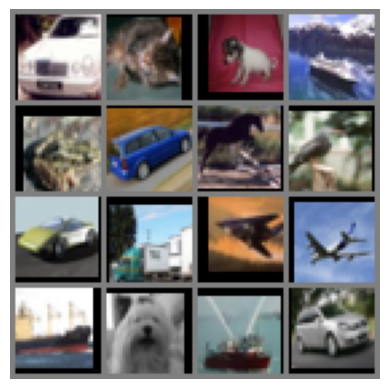

In [41]:
# Get a batch of training data
images, labels = next(iter(train_loader))

# Helper function to show images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize if you normalized with mean=0.5, std=0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # convert from Tensor image
    plt.axis('off')
    plt.show()

# Show images
imshow(torchvision.utils.make_grid(images[:16], nrow=4))  # show first 16 images in a 4x4 grid

In [42]:
train_losses = []
val_losses = []

# Define the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyViT(
    input_shape=(3, 32, 32),
    patch_size=8,        # 32x32 image → 4x4 grid = 16 patches
    n_blocks=4,
    hidden_d=64,
    n_heads=4,
    out_d=10
).to(device)


# Hyperparameters
N_EPOCHS = 100
LR = 0.005
PATIENCE = 5  # Early stopping patience
MIN_DELTA = 0.001  # Minimum improvement to reset early stopping
STEP_SIZE = 10  # StepLR scheduler step size
GAMMA = 0.5     # LR decay factor

optimizer = Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

# Alternatively:
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

best_val_loss = float("inf")
patience_counter = 0

for epoch in range(N_EPOCHS):
    # ---- Training ----
    model.train()
    train_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} Training", leave=False):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)

        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(train_loader)

    # ---- Validation ----
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in test_loader:
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)
            val_loss += loss.item()
    val_loss /= len(test_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{N_EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # ---- Scheduler Step ----
    scheduler.step()  # For StepLR
    # scheduler.step(val_loss)  # If using ReduceLROnPlateau

    # ---- Early Stopping Check ----
    if val_loss + MIN_DELTA < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "vit_best.pth")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"Early stopping at epoch {epoch+1}")
            break

Epoch 1/100 | Train Loss: 1.9030 | Val Loss: 1.7239


Epoch 2/100 | Train Loss: 1.6562 | Val Loss: 1.5850


Epoch 3/100 | Train Loss: 1.5338 | Val Loss: 1.4825


Epoch 4/100 | Train Loss: 1.4504 | Val Loss: 1.4084


Epoch 5/100 | Train Loss: 1.3972 | Val Loss: 1.3933


Epoch 6/100 | Train Loss: 1.3538 | Val Loss: 1.3261


Epoch 7/100 | Train Loss: 1.3102 | Val Loss: 1.3176


Epoch 8/100 | Train Loss: 1.2850 | Val Loss: 1.2726


Epoch 9/100 | Train Loss: 1.2503 | Val Loss: 1.2772


Epoch 10/100 | Train Loss: 1.2313 | Val Loss: 1.2362


Epoch 11/100 | Train Loss: 1.1541 | Val Loss: 1.1642


Epoch 12/100 | Train Loss: 1.1256 | Val Loss: 1.1510


Epoch 13/100 | Train Loss: 1.1127 | Val Loss: 1.1421


Epoch 14/100 | Train Loss: 1.0921 | Val Loss: 1.1412


Epoch 15/100 | Train Loss: 1.0745 | Val Loss: 1.1002


Epoch 16/100 | Train Loss: 1.0611 | Val Loss: 1.1027


Epoch 17/100 | Train Loss: 1.0423 | Val Loss: 1.0945


Epoch 18/100 | Train Loss: 1.0364 | Val Loss: 1.0652


Epoch 19/100 | Train Loss: 1.0231 | Val Loss: 1.0798


Epoch 20/100 | Train Loss: 1.0099 | Val Loss: 1.0828


Epoch 21/100 | Train Loss: 0.9664 | Val Loss: 1.0182


Epoch 22/100 | Train Loss: 0.9554 | Val Loss: 1.0132


Epoch 23/100 | Train Loss: 0.9437 | Val Loss: 0.9966


Epoch 24/100 | Train Loss: 0.9344 | Val Loss: 1.0110


Epoch 25/100 | Train Loss: 0.9347 | Val Loss: 0.9986


Epoch 26/100 | Train Loss: 0.9218 | Val Loss: 0.9870


Epoch 27/100 | Train Loss: 0.9177 | Val Loss: 0.9863


Epoch 28/100 | Train Loss: 0.9142 | Val Loss: 0.9957


Epoch 29/100 | Train Loss: 0.9056 | Val Loss: 0.9926


Epoch 30/100 | Train Loss: 0.8935 | Val Loss: 0.9807


Epoch 31/100 | Train Loss: 0.8714 | Val Loss: 0.9726


Epoch 32/100 | Train Loss: 0.8605 | Val Loss: 0.9506


Epoch 33/100 | Train Loss: 0.8591 | Val Loss: 0.9579


Epoch 34/100 | Train Loss: 0.8544 | Val Loss: 0.9698


Epoch 35/100 | Train Loss: 0.8532 | Val Loss: 0.9589


Epoch 36/100 | Train Loss: 0.8491 | Val Loss: 0.9566


Epoch 37/100 | Train Loss: 0.8413 | Val Loss: 0.9516
Early stopping at epoch 37


In [43]:
import pickle

with open("loss_history.pkl", "wb") as f:
    pickle.dump({"train_losses": train_losses, "val_losses": val_losses}, f)

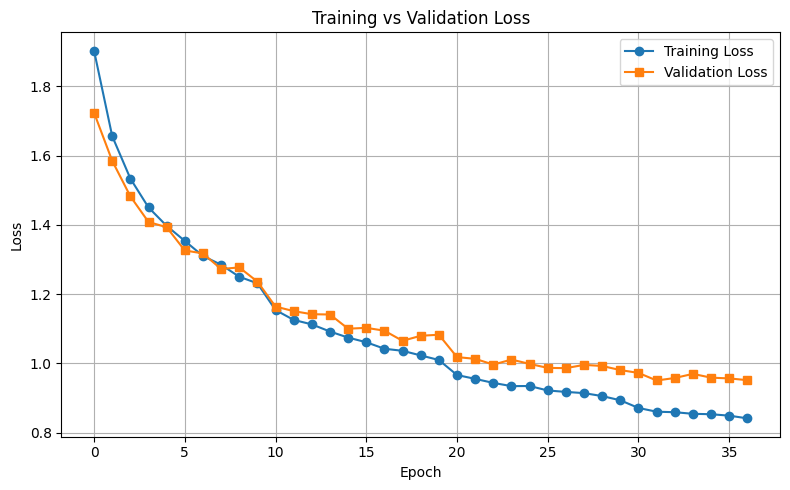

In [44]:
import matplotlib.pyplot as plt
import pickle

# Load the saved losses
with open("loss_history.pkl", "rb") as f:
    loss_dict = pickle.load(f)
    train_losses = loss_dict["train_losses"]
    val_losses = loss_dict["val_losses"]

# Plot the losses
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Training Loss", marker='o')
plt.plot(val_losses, label="Validation Loss", marker='s')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [45]:
# Save losses to file after training
import pickle
with open("loss_history.pkl", "wb") as f:
    pickle.dump((train_losses, val_losses), f)

In [46]:
# Set model to evaluation mode
model.eval()

correct, total = 0, 0
test_loss = 0.0

with torch.no_grad():  # No gradient calculation for evaluation
    for batch in tqdm(test_loader, desc="Testing"):
        x, y = batch
        x, y = x.to(device), y.to(device)

        # Get predictions and compute loss
        y_hat = model(x)
        loss = criterion(y_hat, y)

        # Accumulate test loss
        test_loss += loss.item()  # Use .item() to get the scalar value

        # Compute accuracy
        _, predicted = torch.max(y_hat, dim=1)  # Get the class predictions
        correct += (predicted == y).sum().item()  # Sum the number of correct predictions
        total += y.size(0)  # Total number of samples in this batch

# Calculate final average test loss and accuracy
avg_test_loss = test_loss / len(test_loader)
test_accuracy = (correct / total) * 100

# Print results
print(f"Test Loss: {avg_test_loss:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")

Testing: 100%|██████████| 79/79 [00:04<00:00, 18.15it/s]

Test Loss: 0.97
Test Accuracy: 65.63%


In [ ]:
# Load the pre-trained model
model.load_state_dict(torch.load("vit_cifar10.pth"))
model.to(device)

# This is adapted for transfer learning. Unfreeze all layers if you want full fine-tuning
for param in model.parameters():
    param.requires_grad = True

# Fine-tuning setup
N_EPOCHS_FT = 5
LR_FT = 0.001
PATIENCE = 3
MIN_DELTA = 0.001

optimizer = Adam(model.parameters(), lr=LR_FT)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)
criterion = nn.CrossEntropyLoss()

# Early stopping setup
best_val_loss = float("inf")
patience_counter = 0

for epoch in range(N_EPOCHS_FT):
    model.train()
    train_loss = 0.0
    correct_train, total_train = 0, 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} fine-tuning", leave=False):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)

        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(y_hat, dim=1)
        correct_train += (predicted == y).sum().item()
        total_train += y.size(0)

    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = (correct_train / total_train) * 100

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch + 1}/{N_EPOCHS_FT} | Train Loss: {avg_train_loss:.4f} | "
          f"Train Acc: {train_accuracy:.2f}% | Val Loss: {avg_val_loss:.4f}")

    scheduler.step()

    # Early stopping logic
    if avg_val_loss + MIN_DELTA < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "vit_finetuned_best.pth")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break

In [ ]:
# Load best model after fine-tuning
model.load_state_dict(torch.load("vit_finetuned_best.pth"))